In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
file = np.loadtxt("true.dat", usecols=(0,1))

In [30]:
C1 = file[:,0] * 10**12
Ceq = file[:,1] * 10**12

In [31]:
N = 1000
C1dis = C1 + np.random.normal(loc = 0, scale = 0.5, size = N)
Ceqdis = Ceq + np.random.normal(loc = 0, scale = 0.5, size = N)

In [32]:
np.savetxt('offset.dat', np.stack([C1dis, Ceqdis], axis=1), delimiter = '\t')

In [33]:
from scipy.optimize import curve_fit
def func(x, a, b):
    return 1/((1/(x+a)) + b)

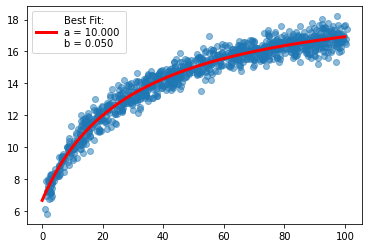

In [40]:
plt.scatter(C1dis, Ceqdis, alpha = 0.5)
# plt.scatter(C1,Ceq, marker = '.')

popt, pcov = curve_fit(func, C1, Ceq)
x = np.linspace(0, 100,300)
plt.plot(x, func(x, *popt), color = 'red', lw = '3',
         label= 'Best Fit:\na = %5.3f \nb = %5.3f' % tuple(popt))

plt.legend()
plt.show()

In [97]:
dCeq = np.random.normal(loc = 0, scale = 3, size = N)
np.savetxt('errorbar.dat', dCeq)

In [98]:
import emcee

In [99]:
def log_likelihood(theta, x, y, yerr):
    a, b, log_f = theta
    model = 1/((1/(x+a)) + b)
    sigma2 = yerr ** 2 + model ** 2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

def log_prior(theta):
    a, b, log_f = theta
    # Return a finite value if theta is in the parameter space region with support for the prior
    if 8.0 < a < 12.0 and -5 < b < 5 and -10.0 < log_f < 1.0:
        return 0.0
    # Otherwise return -infinity, basically a massive down-weight for the posterior
    return -np.inf

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    # If theta is outside the support for the prior, return -infinity
    if not np.isfinite(lp):
        return -np.inf
    # Otherwise return the logarithm of prior*likelihood
    return lp + log_likelihood(theta, x, y, yerr)

Success status: False
Desired error not necessarily achieved due to precision loss.
Maximum likelihood estimates:
a = 10.0526 (True: 10.0000)
q = 0.0500 (True: 0.0500)
f = 0.0023 (True: 1.0000)


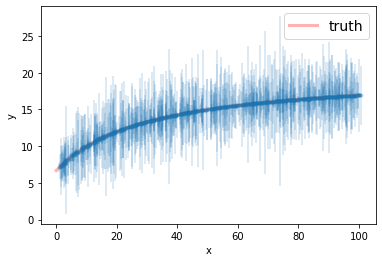

In [106]:
from scipy.optimize import minimize

# Reproducible results
np.random.seed(42)

# Function to minimize: the negative log-likelihood (nll)
nll = lambda *args: -log_likelihood(*args)

# Initial guess for the parameters (make it imperfect with Gaussian noise)
initial = np.array([popt[0], popt[1], np.log(1)]) + 0.1 * np.random.randn(3)

# Solve by minimization of -log-likelihood!
soln = minimize(nll, initial, args=(C1dis, Ceq, dCeq))

# Check it converged
print("Success status:", soln.success)
print(soln.message)

# Extract maximum likelihood parameter values
a_ml, b_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("a = {0:.4f} (True: {1:.4f})".format(a_ml, popt[0]))
print("q = {0:.4f} (True: {1:.4f})".format(b_ml, popt[1]))
print("f = {0:.4f} (True: {1:.4f})".format(np.exp(log_f_ml), 1))


# Plot all together
plt.errorbar(C1dis, Ceq, yerr=dCeq, fmt=".", alpha = 0.2)
plt.plot(x, func(x,*popt), "red", alpha=0.3, lw=3, label="truth")
plt.legend(fontsize=14)
plt.xlabel("x")
plt.ylabel("y");

In [107]:
# The number of walkers
nwalkers = 32

# The dimensionality of the parameter space (m, q, ln(f))
ndim = 3

# The MCMC steps
nmcmc = 5000

# Initial position
pos = soln.x + 1e-4 * np.random.randn(nwalkers, ndim)

# Run the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(C1dis, Ceq, dCeq))
sampler.run_mcmc(pos, nmcmc, progress=True); # The ; avoids some prints to screen

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:28<00:00, 173.76it/s]


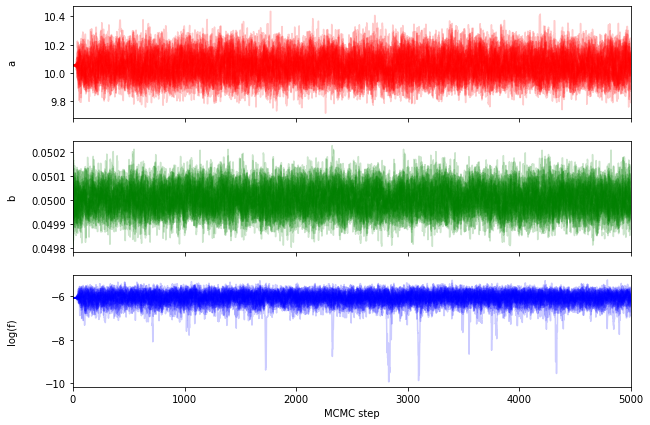

In [108]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["a", "b", "log(f)"]
col = ['r', 'g', 'b']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], col[i], alpha=0.2) # 
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("MCMC step"); # The ; avoids an unwanted output to screen.

In [109]:
tau = sampler.get_autocorr_time()
print(tau)

[36.54061032 35.47087995 37.57853331]


In [110]:
flat_samples = sampler.get_chain(discard=100, thin=20, flat=True)
print(flat_samples.shape)

(7840, 3)


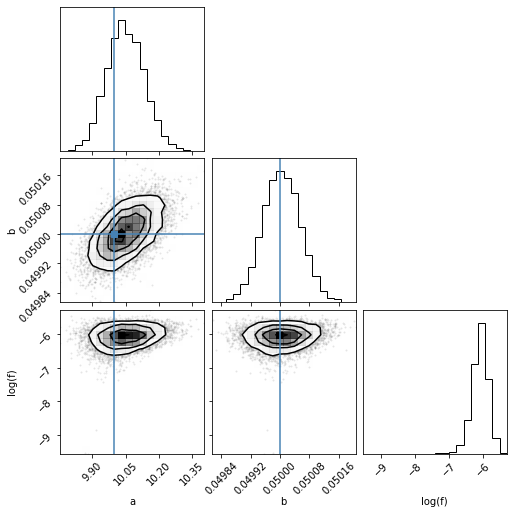

In [111]:
import corner

fig = corner.corner(flat_samples, labels=labels, truths=[popt[0], popt[1], np.log(1)])

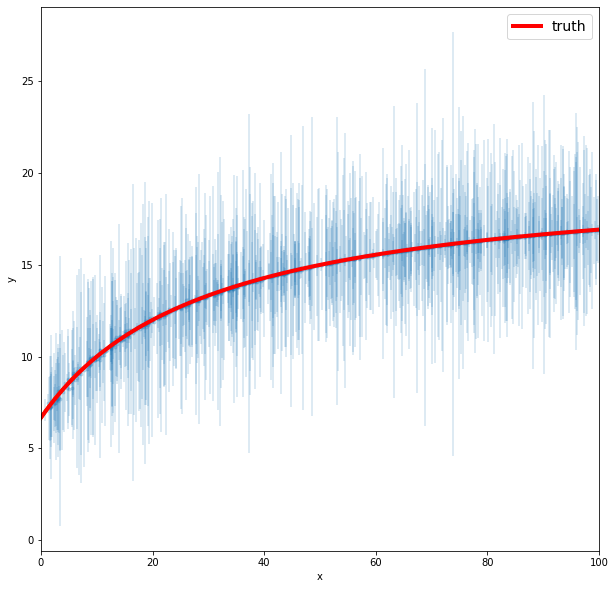

In [127]:
inds = np.random.randint(len(flat_samples), size=100)

fig = plt.figure(figsize=(10,10))
for ind in inds:
    sample = flat_samples[ind]
    plt.plot(x, func(x,sample[0], sample[1]), "C1", alpha=1, zorder = 1)
plt.errorbar(C1dis, Ceq, yerr=dCeq, fmt=".", capsize=0, alpha = 0.2, zorder = 0)
plt.plot(x, func(x,*popt), "red",lw = '4', label="truth")
plt.legend(fontsize=14)
plt.xlim(0, 100)
plt.xlabel("x")
plt.ylabel("y");